In [2]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import re
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

%matplotlib inline

### Setting up and completing the webscrape

In [3]:
# Creating a function that will allow us to iterate through and scrape the info we need from every page
def district_scraper(state, district):
    URL = f'https://www.opensecrets.org/races/candidates?cycle=2020&id={state}{district}&spec=N'
    
    #This initiates a pause after any instance when there's a problem retrieving the page, will repeat up to 10 times
    #before moving on, and it will print out any districts for which any of this applies to allow investigation if needed
    request_url = requests.get(URL)
    tm=0

    while request_url.status_code != 200:
        print('waiting for ' + state + district)
        time.sleep(10)
        request_url = requests.get(URL)
        tm = tm + 1
        if tm == 10:
            break

    soup = BS(request_url.text)

    #pulling the key candidate information
    candidate_list = [x.text.strip() for x in soup.find_all('strong')]
    
    #pulling information about money raised, spent, and cash on hand
    finances = (pd
        .read_html(
            str(soup.findAll('table', attrs={'class' : 'Members--table'}))
                .replace('$','')
                .replace(':', '')
        )
    )
    
    #pulling information about the sources of money raised
    sources = (pd
               .read_html(
                   str(soup.find_all(lambda tag: tag.name == 'div' and 
                                   tag.get('class') == ['u-richtext'])
                       )
                   .replace('$','')
                   .replace('%', '')
               )
              )
    
    #initiating an empty data frame
    temp_df = pd.DataFrame()
    
    #putting different components of the desired data into the empty dataframe
    temp_df['name'] = [re.findall(r'(.+ .+) \(\w', item)[0] for item in candidate_list]
    temp_df['party'] = [re.findall(r'\((\w)\)', item)[0] for item in candidate_list]
    temp_df['vote'] = [re.findall(r'(\d*[.?]\d*\%)', item)[0] for item in candidate_list]
    temp_df['winner'] = ['Winner' if re.search(r'(Winner)', str(item)) is not None
                              else 'Not Winner' for item in candidate_list]
    temp_df['incumbent'] = ['Incumbent' if re.search(r'(Incumbent)', str(item)) != None 
                            else 'Not Incumbent' for item in candidate_list]
    temp_df['state'] = str(re.search(r'[A-Z][a-z]+(?: [A-Z][a-z][a-rt-z][a-z]+)?', 
                                     soup.findAll('title')[0].text)[0])
    temp_df['district'] = str(re.findall(r'District ([0-9]{2})', soup.findAll('title')[0].text)[0])
    temp_df['raised'] = [finances[i].iloc[0,1] for i in range(len(candidate_list))]
    temp_df['spent'] = [finances[i].iloc[1,1] for i in range(len(candidate_list))]
    temp_df['cash_on_hand'] = [finances[i].iloc[2,1] for i in range(len(candidate_list))]
    temp_df['small_indiv_contr'] = [sources[i*2].iloc[0,1] for i in range(len(candidate_list))]
    temp_df['large_indiv_contr'] = [sources[i*2].iloc[1,1] for i in range(len(candidate_list))]
    temp_df['PAC_contr'] = [sources[i*2].iloc[2,1] for i in range(len(candidate_list))]
    temp_df['self_financing'] = [sources[i*2].iloc[3,1] for i in range(len(candidate_list))]
    temp_df['other_sources'] = [sources[i*2].iloc[4,1] for i in range(len(candidate_list))]
    temp_df['small_indiv_contr_perc'] = [sources[i*2].iloc[0,2] for i in range(len(candidate_list))]
    temp_df['large_indiv_contr_perc'] = [sources[i*2].iloc[1,2] for i in range(len(candidate_list))]
    temp_df['PAC_contr_perc'] = [sources[i*2].iloc[2,2] for i in range(len(candidate_list))]
    temp_df['self_financing_perc'] = [sources[i*2].iloc[3,2] for i in range(len(candidate_list))]
    temp_df['other_sources_perc'] = [sources[i*2].iloc[4,2] for i in range(len(candidate_list))]
    
    #adding the information gathered from each page to the primary data frame
    #declaring candidate_df as global allows us to create the empty df before running the function
    #then call it after the function is done running
    global candidate_df
    candidate_df = pd.concat([candidate_df, temp_df])
    candidate_df = candidate_df.reset_index(drop=True)

In [4]:
#Scraping information about the number of district in each state
district_url = 'https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120'
district_soup = BS(requests.get(district_url).text)
district_df = pd.read_html(str(district_soup.find('table')))[0]

#Scraping state abbreviation detail for each state to allow us to make a dictionary
state_url = 'https://www.50states.com/abbreviations.htm'
state_soup = BS(requests.get(state_url).text)

state_df = (
    pd.read_html(str(state_soup.find('table', 
                                            attrs={'class' : 'table table-hover'})))[0]
    .drop(columns = 'STANDARD ABBREVIATION')
    .rename(columns = {'US STATE' : 'state',
                       'POSTAL ABBREVIATION' : 'abbrev'})
)

#Combining the district information with the state abbreviations and making the dictionary
state_details = pd.merge(state_df, district_df, how='inner', on='state')
district_dictionary = state_details.set_index('abbrev')['representatives'].to_dict()
district_dictionary

{'AL': 7,
 'AK': 1,
 'AZ': 9,
 'AR': 4,
 'CA': 53,
 'CO': 7,
 'CT': 5,
 'DE': 1,
 'FL': 27,
 'GA': 14,
 'HI': 2,
 'ID': 2,
 'IL': 18,
 'IN': 9,
 'IA': 4,
 'KS': 4,
 'KY': 6,
 'LA': 6,
 'ME': 2,
 'MD': 8,
 'MA': 9,
 'MI': 14,
 'MN': 8,
 'MS': 4,
 'MO': 8,
 'MT': 1,
 'NE': 3,
 'NV': 4,
 'NH': 2,
 'NJ': 12,
 'NM': 3,
 'NY': 27,
 'NC': 13,
 'ND': 1,
 'OH': 16,
 'OK': 5,
 'OR': 5,
 'PA': 18,
 'RI': 2,
 'SC': 7,
 'SD': 1,
 'TN': 9,
 'TX': 36,
 'UT': 4,
 'VT': 1,
 'VA': 11,
 'WA': 10,
 'WV': 3,
 'WI': 8,
 'WY': 1}

In [5]:
#Using the dictionary to iterate through all the candidate pages for every state/district and creating our dataframe
candidate_df = pd.DataFrame()

for key, val in district_dictionary.items():
        for num in range(1, val + 1):
            district_scraper(key, str(num).zfill(2))

waiting for NY21
waiting for NY21
waiting for NY21
waiting for NY21
waiting for NY21
waiting for NY21
waiting for NY21


In [6]:
#Taking a look at the results
candidate_df

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,small_indiv_contr,large_indiv_contr,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,44580,999616,387000,434656,105470,2.26,50.71,19.63,22.05,5.35
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,12895,37955,0,29245,0,16.10,47.39,0.00,36.51,0.00
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,62208,346329,230282,11500,489,9.56,53.22,35.38,1.77,0.08
3,Phyllis Harvey-Hall,D,34.6%,Not Winner,Not Incumbent,Alabama,02,56050,55988,0,15307,27105,2032,10575,1030,27.31,48.36,3.63,18.87,1.84
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,5315,438054,744734,0,5009,0.45,36.72,62.42,0.00,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,Tricia Zunker,D,39.2%,Not Winner,Not Incumbent,Wisconsin,07,1261957,1232690,29267,600015,566860,91807,0,3276,47.55,44.92,7.27,0.00,0.26
888,Mike Gallagher,R,64.0%,Winner,Incumbent,Wisconsin,08,3202905,2841801,1169362,188430,2040299,841300,0,132876,5.88,63.70,26.27,0.00,4.15
889,Amanda Stuck,D,36.0%,Not Winner,Not Incumbent,Wisconsin,08,416978,399916,2165,169380,221453,30183,0,-4038,40.62,53.11,7.24,0.00,-0.97
890,Liz Cheney,R,68.6%,Winner,Incumbent,Wyoming,01,3003883,3060167,153567,189647,980349,1292490,0,541398,6.31,32.64,43.03,0.00,18.02


#### Sanity Check
You can use this code to make sure data was captured for all districts in all states
counts = candidate_df.groupby('state')['district'].nunique().to_frame().reset_index()
sanity_check = pd.merge(counts, state_details, on='state')
sanity_check['district'].sum()
sanity_check['representatives'].sum()

#### Another way to iterate through the financial data, pulling pivoted values and concatting them
##### intitialize empty data frame
final_finances = pd.DataFrame()

###### create the list of all dataframe tables for candidates
finances = (pd
    .read_html(
        str(soup_TN07.findAll('table', attrs={'class' : 'Members--table'}))
            .replace('$','')
            .replace(':', '')
    )
)

for fin in finances:
    final_finances = pd.concat(
        [final_finances,
        fin.pivot(index=2, columns=0, values=1).reset_index(drop=True)])

#### Another way to get the funding source info:   
  
funding_source = (pd
    .read_html(
        str([table for table in soup.findAll('table') 
                if re.search(r'(Type of Contribution)', str(table)) != None ]
            )
            .replace('$','')
    )
)   

temp_df['Small Individual Contributions (≤ 200)'] = [funding_source[i].iloc[0,1] for i in range(len(candidate_list))]   
temp_df['Large Individual Contributions'] = [funding_source[i].iloc[1,1] for i in range(len(candidate_list))]   
temp_df['PAC Contributions*'] = [funding_source[i].iloc[2,1] for i in range(len(candidate_list))]   
temp_df['Candidate self-financing'] = [funding_source[i].iloc[3,1] for i in range(len(candidate_list))]   
temp_df['Other'] = [funding_source[i].iloc[4,1] for i in range(len(candidate_list))]   

### Exploratory Data Analysis

Using your scraped data, investigates different relationships between candidates and the amount of money they raised.  

    a. How often does the candidate who raised more money win a race?

In [7]:
#Adding in a column that shows the maximum amount raised in each race
candidate_df['max_raised'] = (
    candidate_df
    .groupby(['state', 'district'])['raised']
    .transform(max)
)

#Finding those rows where the amount raised equals the max raised AND the candidate was the winner (384 instances)
(
    candidate_df
    .loc[(candidate_df['raised'] == candidate_df['max_raised']) 
         & 
         (candidate_df['winner'] == 'Winner')]
)

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,...,large_indiv_contr,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc,max_raised
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,...,999616,387000,434656,105470,2.26,50.71,19.63,22.05,5.35,1971321
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,...,346329,230282,11500,489,9.56,53.22,35.38,1.77,0.08,650807
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,...,438054,744734,0,5009,0.45,36.72,62.42,0.00,0.42,1193111
6,Robert B Aderholt,R,82.5%,Winner,Incumbent,Alabama,04,1255076,1323812,647004,...,479663,739300,0,-25346,4.90,38.22,58.90,0.00,-2.02,1255076
7,Mo Brooks,R,95.8%,Winner,Incumbent,Alabama,05,655365,210045,1137501,...,395551,250020,0,-12010,3.33,60.36,38.15,0.00,-1.83,655365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,Scott Fitzgerald,R,60.2%,Winner,Not Incumbent,Wisconsin,05,1155721,968406,187315,...,602991,322613,250,20246,18.14,52.17,27.91,0.02,1.75,1155721
884,Glenn S Grothman,R,59.3%,Winner,Incumbent,Wisconsin,06,1815756,1736659,269431,...,1031334,386784,0,132467,14.60,56.80,21.30,0.00,7.30,1815756
886,Tom Tiffany,R,60.8%,Winner,Incumbent,Wisconsin,07,2637459,2514740,122719,...,1716838,363117,0,38716,19.67,65.09,13.77,0.00,1.47,2637459
888,Mike Gallagher,R,64.0%,Winner,Incumbent,Wisconsin,08,3202905,2841801,1169362,...,2040299,841300,0,132876,5.88,63.70,26.27,0.00,4.15,3202905


In [8]:
#Another way to look at the number of candidates who raised the most money and won compared to those who raised
#the most money and didn't win
candidate_df[
    candidate_df['raised']
    .isin(candidate_df.groupby(by=['state', 'district'])['raised'].max())
    ].groupby(by='winner').count()

,name,party,vote,incumbent,state,district,raised,spent,cash_on_hand,small_indiv_contr,large_indiv_contr,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc,max_raised
winner,,,,,,,,,,,,,,,,,,,,
Not Winner,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
Winner,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384


- The candidate who raised the most money was also the winner in 384 of the races

    b. How often does the candidate who spent more money win a race? 

In [9]:
#Completing same steps as above but with money spent instead of money raised
candidate_df['max_spent'] = (
    candidate_df
    .groupby(['state', 'district'])['spent']
    .transform('max')
)

(
    candidate_df
    .loc[(candidate_df['spent'] == candidate_df['max_spent']) 
         & 
         (candidate_df['winner'] == 'Winner')]
)
#381 candidates spent the most and won their race

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,...,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc,max_raised,max_spent
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,...,387000,434656,105470,2.26,50.71,19.63,22.05,5.35,1971321,1859349
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,...,230282,11500,489,9.56,53.22,35.38,1.77,0.08,650807,669368
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,...,744734,0,5009,0.45,36.72,62.42,0.00,0.42,1193111,1218564
6,Robert B Aderholt,R,82.5%,Winner,Incumbent,Alabama,04,1255076,1323812,647004,...,739300,0,-25346,4.90,38.22,58.90,0.00,-2.02,1255076,1323812
7,Mo Brooks,R,95.8%,Winner,Incumbent,Alabama,05,655365,210045,1137501,...,250020,0,-12010,3.33,60.36,38.15,0.00,-1.83,655365,210045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,Scott Fitzgerald,R,60.2%,Winner,Not Incumbent,Wisconsin,05,1155721,968406,187315,...,322613,250,20246,18.14,52.17,27.91,0.02,1.75,1155721,968406
884,Glenn S Grothman,R,59.3%,Winner,Incumbent,Wisconsin,06,1815756,1736659,269431,...,386784,0,132467,14.60,56.80,21.30,0.00,7.30,1815756,1736659
886,Tom Tiffany,R,60.8%,Winner,Incumbent,Wisconsin,07,2637459,2514740,122719,...,363117,0,38716,19.67,65.09,13.77,0.00,1.47,2637459,2514740
888,Mike Gallagher,R,64.0%,Winner,Incumbent,Wisconsin,08,3202905,2841801,1169362,...,841300,0,132876,5.88,63.70,26.27,0.00,4.15,3202905,2841801


In [10]:
candidate_df[
    candidate_df['spent']
    .isin(candidate_df.groupby(by=['state', 'district'])['spent'].max())
    ].groupby(by='winner').count()

,name,party,vote,incumbent,state,district,raised,spent,cash_on_hand,small_indiv_contr,...,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc,max_raised,max_spent
winner,,,,,,,,,,,,,,,,,,,,,
Not Winner,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
Winner,381,381,381,381,381,381,381,381,381,381,...,381,381,381,381,381,381,381,381,381,381


- The candidate who spent the most money was the winner in 381 races

    c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

In [11]:
# Creating columns that show the difference between the max raised/spent in that race and the amount a given candidate
# raised/spent
candidate_df['raised_dif'] = candidate_df['max_raised'] - candidate_df['raised']
candidate_df['spent_dif'] = candidate_df['max_spent'] - candidate_df['spent']
candidate_df

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,...,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,PAC_contr_perc,self_financing_perc,other_sources_perc,max_raised,max_spent,raised_dif,spent_dif
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,...,105470,2.26,50.71,19.63,22.05,5.35,1971321,1859349,0,0
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,...,0,16.10,47.39,0.00,36.51,0.00,1971321,1859349,1891226,1780376
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,...,489,9.56,53.22,35.38,1.77,0.08,650807,669368,0,0
3,Phyllis Harvey-Hall,D,34.6%,Not Winner,Not Incumbent,Alabama,02,56050,55988,0,...,1030,27.31,48.36,3.63,18.87,1.84,650807,669368,594757,613380
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,...,5009,0.45,36.72,62.42,0.00,0.42,1193111,1218564,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,Tricia Zunker,D,39.2%,Not Winner,Not Incumbent,Wisconsin,07,1261957,1232690,29267,...,3276,47.55,44.92,7.27,0.00,0.26,2637459,2514740,1375502,1282050
888,Mike Gallagher,R,64.0%,Winner,Incumbent,Wisconsin,08,3202905,2841801,1169362,...,132876,5.88,63.70,26.27,0.00,4.15,3202905,2841801,0,0
889,Amanda Stuck,D,36.0%,Not Winner,Not Incumbent,Wisconsin,08,416978,399916,2165,...,-4038,40.62,53.11,7.24,0.00,-0.97,3202905,2841801,2785927,2441885
890,Liz Cheney,R,68.6%,Winner,Incumbent,Wyoming,01,3003883,3060167,153567,...,541398,6.31,32.64,43.03,0.00,18.02,3003883,3060167,0,0


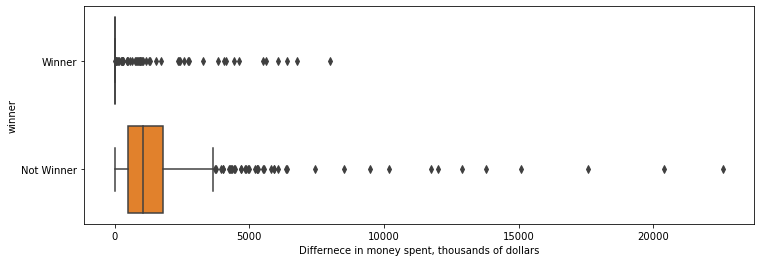

In [12]:
#Plotting the money spent difference values, reminder that 0 means they spent the most
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=candidate_df, 
            x=candidate_df['spent_dif']/1000, 
            y='winner', 
            ax=ax
)
plt.xlabel('Differnece in money spent, thousands of dollars');
#This distribution supports the idea that those that spend the most are most often the winners

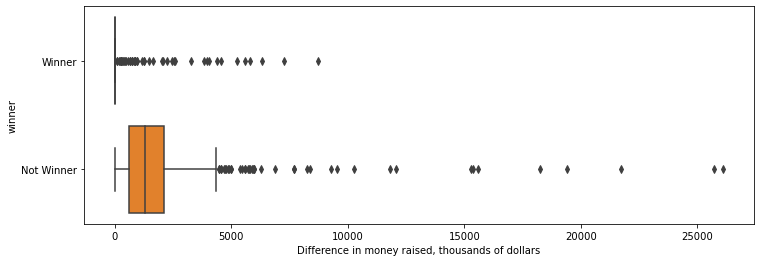

In [13]:
#Same type of plot for the values of the difference in the amount raised
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=candidate_df, 
            x=candidate_df['raised_dif']/1000, 
            y='winner', 
            ax=ax
)
plt.xlabel('Difference in money raised, thousands of dollars');
#This distribution again supports the idea that the person who raises the most tends to be the winner

    d. How often does the incumbent candidate win a race?  

In [14]:
len(candidate_df.loc[(candidate_df['incumbent'] == 'Incumbent') & (candidate_df['winner'] == 'Winner')])

371

- The incumbent was the winner in 371 races

    e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

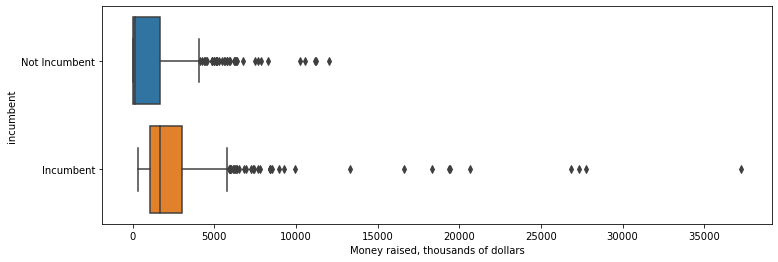

In [15]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=candidate_df, 
            x=candidate_df['raised']/1000, 
            y='incumbent', 
            ax=ax
)
plt.xlabel('Money raised, thousands of dollars');
#This distribution indicates that incumbents, on average, raise more money that non-incumbents
#The median amount raised by incumbents is roughly equivalent to the Q3 value for non-incumbents

In [16]:
candidate_df.groupby('incumbent')['raised'].describe()

,count,mean,std,min,25%,50%,75%,max
incumbent,,,,,,,,
Incumbent,386.0,2.821432e+06,3.860280e+06,327727.0,1075136.25,1700519.5,3004570.00,37262827.0
Not Incumbent,506.0,1.143709e+06,1.896553e+06,-2084.0,35003.75,171396.5,1657891.75,12050564.0


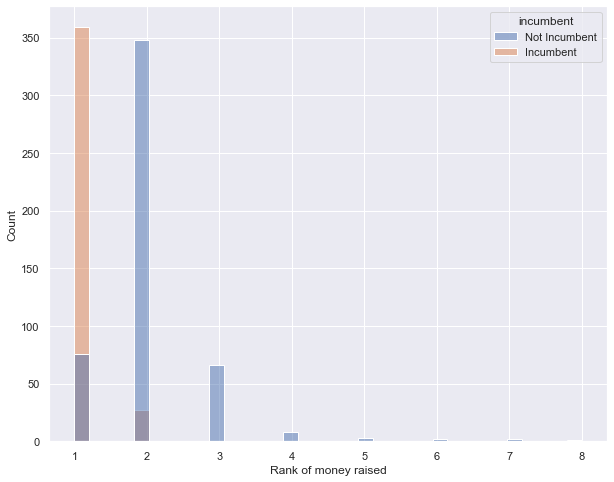

In [17]:
#Creating a column that ranks the amount raised in a given race with rank of 1 being assigned to the top money raiser
candidate_df['raised_rank'] = (
    candidate_df.groupby(['state', 'district'])['raised']
    .rank(method='first', ascending=False)
)

#Plotting the ranks, with hue representing incumbency statsu
sns.set(rc={"figure.figsize":(10, 8)})
sns.histplot(
    data = candidate_df, 
    x = 'raised_rank', 
    hue = 'incumbent'
)
plt.xlabel('Rank of money raised');
#This again demonstrates that the incumbent is much more likely to raise the most money in a given race

    Our own additional EDA

In [18]:
#Creating dummy numeric columns to correspond to winner/incumbent (1) or not winner/not incumbent (0)
candidate_df['winner_dum'] = pd.get_dummies(candidate_df['winner'])['Winner']
candidate_df['incumbent_dum'] = pd.get_dummies(candidate_df['incumbent'])['Incumbent']

#Creating a colun
candidate_df['num_of_candidates'] = candidate_df.groupby(['state', 'district'])['name'].transform('count')

#Looking at correlations between all of our numeric values
candidate_df.corr()

,raised,spent,cash_on_hand,small_indiv_contr,large_indiv_contr,PAC_contr,self_financing,other_sources,small_indiv_contr_perc,large_indiv_contr_perc,...,self_financing_perc,other_sources_perc,max_raised,max_spent,raised_dif,spent_dif,raised_rank,winner_dum,incumbent_dum,num_of_candidates
raised,1.000000,0.977278,0.585574,0.872178,0.925212,0.403251,0.132431,0.639869,0.087209,-0.011133,...,-0.173160,0.025810,0.758857,0.749271,-0.106332,-0.112277,-0.317483,0.272329,0.274661,-0.104805
spent,0.977278,1.000000,0.437322,0.821708,0.914755,0.412693,0.157894,0.651606,0.075269,-0.010383,...,-0.173461,0.027297,0.748107,0.775835,-0.094004,-0.100469,-0.313872,0.248204,0.251672,-0.103256
cash_on_hand,0.585574,0.437322,1.000000,0.557590,0.494761,0.374852,-0.043015,0.298136,-0.049898,-0.021620,...,-0.154662,0.013927,0.373293,0.256253,-0.170780,-0.174880,-0.300468,0.388391,0.413044,-0.130955
small_indiv_contr,0.872178,0.821708,0.557590,1.000000,0.700004,0.100996,0.009721,0.463152,0.310045,-0.013185,...,-0.104566,0.010880,0.723261,0.682289,0.001008,-0.011944,-0.142697,0.090525,0.085079,-0.036928
large_indiv_contr,0.925212,0.914755,0.494761,0.700004,1.000000,0.378526,0.034128,0.567370,0.033589,0.014866,...,-0.218053,0.026390,0.698910,0.703164,-0.103255,-0.102210,-0.310747,0.222443,0.238241,-0.087649
PAC_contr,0.403251,0.412693,0.374852,0.100996,0.378526,1.000000,-0.056942,0.193521,-0.400875,-0.046310,...,-0.308699,0.030794,0.139157,0.160504,-0.297627,-0.293264,-0.526084,0.650436,0.723581,-0.221095
self_financing,0.132431,0.157894,-0.043015,0.009721,0.034128,-0.056942,1.000000,0.004414,-0.078170,-0.022282,...,0.300252,0.003213,0.100681,0.116630,-0.013800,-0.025119,-0.043843,0.036637,-0.101814,-0.018721
other_sources,0.639869,0.651606,0.298136,0.463152,0.567370,0.193521,0.004414,1.000000,-0.002856,-0.007631,...,-0.078440,0.024956,0.483793,0.504385,-0.070750,-0.067285,-0.127794,0.124200,0.143186,-0.066234
small_indiv_contr_perc,0.087209,0.075269,-0.049898,0.310045,0.033589,-0.400875,-0.078170,-0.002856,1.000000,0.120052,...,-0.171797,-0.145140,0.219209,0.198983,0.224370,0.214134,0.298613,-0.449486,-0.445989,0.083159
large_indiv_contr_perc,-0.011133,-0.010383,-0.021620,-0.013185,0.014866,-0.046310,-0.022282,-0.007631,0.120052,1.000000,...,-0.077043,-0.986018,0.003377,0.000866,0.019239,0.015112,0.012087,-0.051382,-0.051434,-0.006907


### Logistic Regression   
Now, take the data you gathered and fit a logistic regression model to see if the amount spent has a statistically significant impact on the probability of winning an election.

Feel free to brainstorm ways to set up your model, but a suggestion to get started would be to calculate, for each candidate, the percentage of to total amount spent in their race that was spent by them and use this as your predictor variable of interest. Hint: you may find the `transform` method (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) in combination with `groupby` useful to find the total spending by race.

Don't forget to include the incumbent variable in your model.

After fitting your model, interpret the meaning of the coefficients you get.

In [19]:
#Creating a column of the total amount spent for each race
candidate_df['total_spent'] = (
    candidate_df.groupby(['state', 'district'])['spent']
    .transform('sum')
)

#Creating a column that shows the percentage of the total spent by each candidate
candidate_df['perc_total_spent'] = (candidate_df['spent'] * 100 / candidate_df['total_spent']).round(2)

In [20]:
#Initial logistic regression between winning status and percent of total spent by a candidate
candidate_logreg = smf.logit("winner_dum ~ perc_total_spent",
                          data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.243753
         Iterations 8


In [21]:
candidate_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.6481
Time:                        16:19:24   Log-Likelihood:                -217.43
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                3.781e-176
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.4758      0.310    -14.420      0.000      -5.084      -3.867
perc_total_spent     0.0886      0.006     15.653      0.000       0.077       0.100
====================================================================================
"""

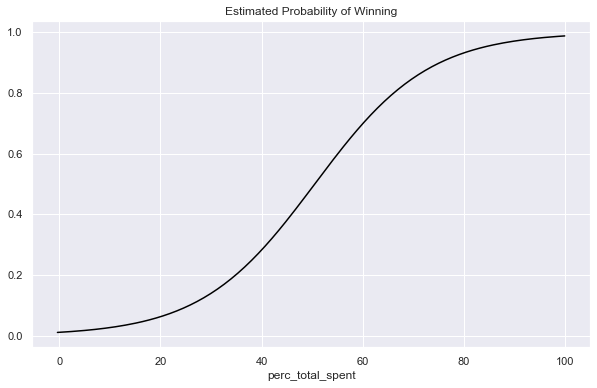

In [22]:
#Plotting the model
fit_df = pd.DataFrame({
    'perc_total_spent': np.linspace(start = candidate_df['perc_total_spent'].min(),
                            stop = candidate_df['perc_total_spent'].max(),
                            num = 150)
})

fit_df['fit'] = candidate_logreg.predict(fit_df)

fit_df.plot(x = 'perc_total_spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of Winning');

In [23]:
#Creating a dataframe that provides the empirical and modeled probabilities
candidate_summary = (
    candidate_df
    .assign(group = pd.qcut(candidate_df['perc_total_spent'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group')
    ['winner_dum', 'perc_total_spent']
    .mean()
    .reset_index()
    .rename(columns = {'winner_dum': 'eprob'})
)

candidate_summary['fit_prob'] = candidate_logreg.predict(candidate_summary[['perc_total_spent']])

candidate_summary

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_61081/2979609926.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  candidate_df


,group,eprob,perc_total_spent,fit_prob
0,"(-0.391, 0.974]",0.000000,0.283667,0.011536
1,"(0.974, 4.762]",0.000000,2.692247,0.014240
2,"(4.762, 14.528]",0.011236,8.526629,0.023645
3,"(14.528, 31.44]",0.155556,23.191000,0.081512
4,"(31.44, 47.72]",0.318182,39.478523,0.272980
5,"(47.72, 64.64]",0.566667,55.948667,0.617522
6,"(64.64, 81.839]",0.818182,72.666591,0.876488
7,"(81.839, 94.022]",0.977528,88.781910,0.967288
8,"(94.022, 98.984]",0.988764,96.582472,0.983334
9,"(98.984, 100.0]",1.000000,99.857778,0.987478


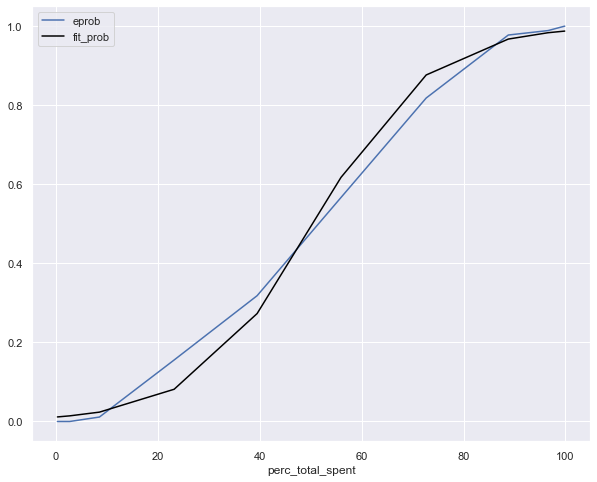

In [24]:
#Plotting the empirical and modeled probabilities for comparison
ax = candidate_summary.plot(x = 'perc_total_spent', y = 'eprob')
candidate_summary.plot(x = 'perc_total_spent', y = 'fit_prob',
                color = 'black',
                ax = ax);

In [25]:
#Adding the empirical and modeled log-odds to our dataframe
candidate_summary['elogit'] = np.log(candidate_summary['eprob'] / (1 - candidate_summary['eprob']))
candidate_summary['fit_logit'] = np.log(candidate_summary['fit_prob'] / (1 - candidate_summary['fit_prob']))
candidate_summary

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,group,eprob,perc_total_spent,fit_prob,elogit,fit_logit
0,"(-0.391, 0.974]",0.000000,0.283667,0.011536,-inf,-4.450653
1,"(0.974, 4.762]",0.000000,2.692247,0.014240,-inf,-4.237349
2,"(4.762, 14.528]",0.011236,8.526629,0.023645,-4.477337,-3.720656
3,"(14.528, 31.44]",0.155556,23.191000,0.081512,-1.691676,-2.421978
4,"(31.44, 47.72]",0.318182,39.478523,0.272980,-0.762140,-0.979554
5,"(47.72, 64.64]",0.566667,55.948667,0.617522,0.268264,0.479044
6,"(64.64, 81.839]",0.818182,72.666591,0.876488,1.504077,1.959584
7,"(81.839, 94.022]",0.977528,88.781910,0.967288,3.772761,3.386758
8,"(94.022, 98.984]",0.988764,96.582472,0.983334,4.477337,4.077576
9,"(98.984, 100.0]",1.000000,99.857778,0.987478,inf,4.367638


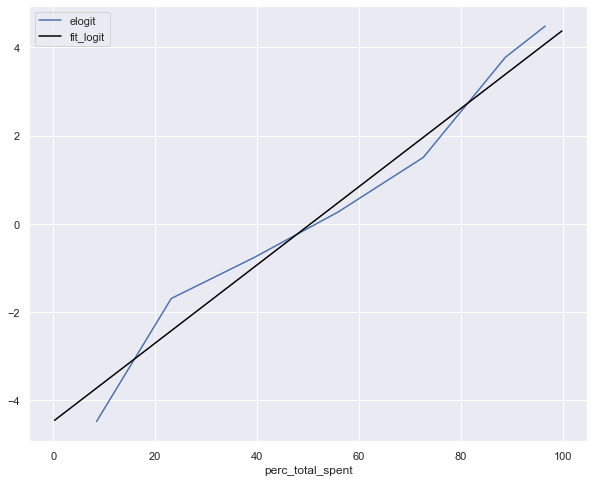

In [26]:
#Plotting the empirical and modeled log-odds for comparison
ax = candidate_summary.plot(x = 'perc_total_spent', y = 'elogit')
candidate_summary.plot(x = 'perc_total_spent', y = 'fit_logit',
                color = 'black',
                ax = ax);

In [27]:
#Creating a function that does some of th work we did above all at once for other variables
def summary_by_var(var, q = 10):
    return (
        candidate_df
        .assign(group = pd.qcut(candidate_df[var], 
                                q = q, 
                                duplicates = 'drop'))
        .groupby('group')
        ['winner_dum']
        .mean()
        .reset_index()
        .rename(columns = {'winner_dum': 'eprob'})
    )

In [28]:
#looking at the empirical probability of winning based on the percent of total spent by a candidate
summary_by_var('perc_total_spent')

,group,eprob
0,"(-0.391, 0.974]",0.000000
1,"(0.974, 4.762]",0.000000
2,"(4.762, 14.528]",0.011236
3,"(14.528, 31.44]",0.155556
4,"(31.44, 47.72]",0.318182
5,"(47.72, 64.64]",0.566667
6,"(64.64, 81.839]",0.818182
7,"(81.839, 94.022]",0.977528
8,"(94.022, 98.984]",0.988764
9,"(98.984, 100.0]",1.000000


In [29]:
#looking at incumbency status and winning status
var = 'incumbent_dum'

pd.crosstab(candidate_df[var],
            candidate_df['winner_dum'],
            normalize = 'index')

winner_dum,0,1
incumbent_dum,,
0,0.881423,0.118577
1,0.038860,0.961140


In [30]:
#Looking at empirical probabilities based on the number of candidates in the race
summary_by_var('num_of_candidates', 6)

,group,eprob
0,"(0.999, 2.0]",0.539823
1,"(2.0, 3.0]",0.333333
2,"(3.0, 8.0]",0.175000


In [31]:
#Creating models
reduced_model = smf.logit('winner_dum ~ 1', #this a model that doesn't consider any other variables
                        data = candidate_df).fit()

full_model = smf.logit('winner_dum ~ perc_total_spent',
                    data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.692582
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.243753
         Iterations 8


In [32]:
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      891
Method:                           MLE   Df Model:                            0
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:               9.165e-11
Time:                        16:19:24   Log-Likelihood:                -617.78
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0673      0.067     -1.004      0.315      -0.199       0.064
==============================================================================
"""

In [33]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.6481
Time:                        16:19:24   Log-Likelihood:                -217.43
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                3.781e-176
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.4758      0.310    -14.420      0.000      -5.084      -3.867
perc_total_spent     0.0886      0.006     15.653      0.000       0.077       0.100
====================================================================================
"""

In [34]:
#Creating a function to run a chi square to assess the significance of the variables chosen on the model
def dd_test(reduced_model, full_model):
    G2 = -2 * (reduced_model.llf - full_model.llf)
    df = full_model.df_model - reduced_model.df_model
    return chi2.sf(G2, df = df)

In [35]:
dd_test(reduced_model, full_model)
#This indicates support of rejecting the null hypothesis, or, in other words, in this case the percent of total spent
#by a candidates has a strong association with whether a candidate wins or not such that larger percent spent aligns
#with being the winner of the race

3.7812306868186874e-176

In [36]:
#Adding in incumbency status to the model
reduced_model = smf.logit('winner_dum ~ perc_total_spent',
                        data = candidate_df).fit()

full_model = smf.logit('winner_dum ~ perc_total_spent + incumbent_dum',
                    data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.243753
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182460
         Iterations 8


In [37]:
dd_test(reduced_model, full_model)
#Again, this value supports rejecting the null, meaning that incumbency status has a strong association with whether
#a given candidate wins such that incumbents are much more likely to be winners than non-winner

1.363143088610387e-25

In [38]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.7366
Time:                        16:19:24   Log-Likelihood:                -162.75
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                2.420e-198
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.3755      0.333    -13.136      0.000      -5.028      -3.723
perc_total_spent     0.0623      0.006     10.546      0.000       0.051       0.074
incumbent_dum        3.2073      0.339      9.467      0.000       2.543       3.871
====================================================================================
"""

In [39]:
np.exp(full_model.params['incumbent_dum'])

24.711258505291337

In [40]:
np.exp(full_model.params['perc_total_spent'])

1.0643221595712755

Translating the two values above: 
- Being an incumbent increases the odds of winning a race by a factor of 24.71
- Every additional percent of the total spend amount spent by a candidate increases their odds of winning by a factor of 1.06

### Bonus Questions:
Open Secrets also gives a detailed breakdown of contributions by source.   
See if you can find anything interesting in terms of the source of contributions. Some examples to get you started:
* What does the overall distribution of funding sources look like?

In [41]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
#We got some warnings for a few of our plots and just wanted to clear them out for the purpose of 
#keeping the final notebook clean in appearance

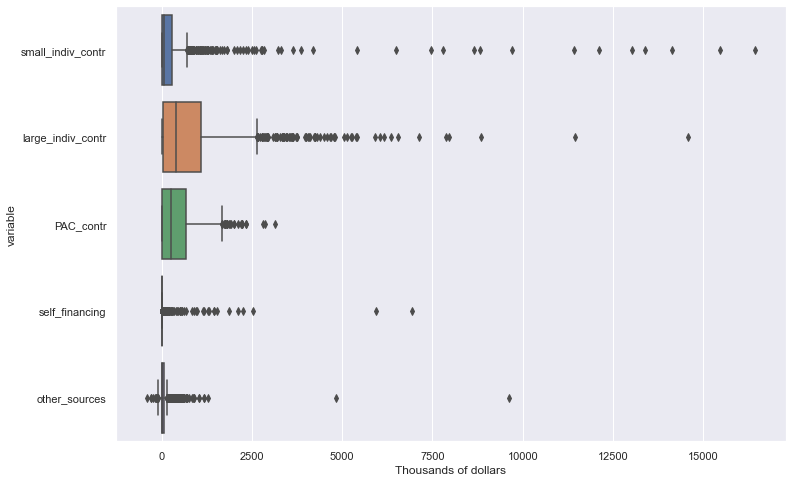

In [42]:
#Plotting the distribution of amount of money from different sources, in thousands of dollars
fig, ax = plt.subplots(figsize = (12,8))

#using the .melt function to allow plotting all funding sources on one plot
sns.boxplot(
            data=pd.melt(candidate_df[['small_indiv_contr', 'large_indiv_contr', 'PAC_contr',
                                   'self_financing', 'other_sources']]), 
            x=(pd.melt(candidate_df[['small_indiv_contr', 'large_indiv_contr', 'PAC_contr',
                                   'self_financing', 'other_sources']])['value']/1000), 
            y='variable', 
            ax=ax
)
plt.xlabel('Thousands of dollars');

We can see from the above that on average, the largest amounts of money were provided by large individual contributions or PAC contributions, though there are a handful of very high outlier values for small individual contributions. Self financing and "other" sources tend to play a smaller role, though, again, there are a couple of moderately large values that are exceptions to this rule

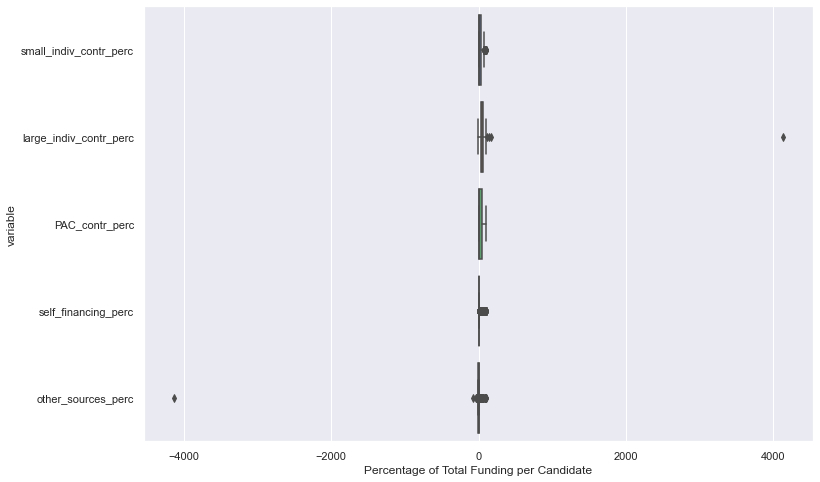

In [43]:
#Plotting the distribution of funding sources by percentage of a candidate's total funding
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=pd.melt(candidate_df[['small_indiv_contr_perc', 'large_indiv_contr_perc', 'PAC_contr_perc',
                                       'self_financing_perc', 'other_sources_perc']]), 
            x='value', 
            y='variable', 
            ax=ax
)
plt.xlabel('Percentage of Total Funding per Candidate');

In [44]:
#investigating the weird values show above
candidate_df['large_indiv_contr_perc'].sort_values().tail(10)

240      94.23
489      94.52
185      95.91
171      98.67
712      99.34
438     100.00
816     110.00
647     139.16
527     166.09
529    4126.98
Name: large_indiv_contr_perc, dtype: float64

In [45]:
candidate_df.iloc[529]

name                           Amit Lal
party                                 I
vote                               0.0%
winner                       Not Winner
incumbent                 Not Incumbent
state                          New York
district                             05
raised                              126
spent                                 0
cash_on_hand                        126
small_indiv_contr                   126
large_indiv_contr                  5200
PAC_contr                             0
self_financing                        0
other_sources                     -5200
small_indiv_contr_perc            100.0
large_indiv_contr_perc          4126.98
PAC_contr_perc                      0.0
self_financing_perc                 0.0
other_sources_perc             -4126.98
max_raised                      2097572
max_spent                       1467454
raised_dif                      2097446
spent_dif                       1467454
raised_rank                         2.0


This one candidate's percentage of funding values are making it very difficult to see what's going on with the rest of the candidates, so we will remove it when looking at these columns. Given the fact that this candidate did not receive any of the vote and did not raise a significant amount of money, we don't need to worry too much that we are missing out on important data by removing them.

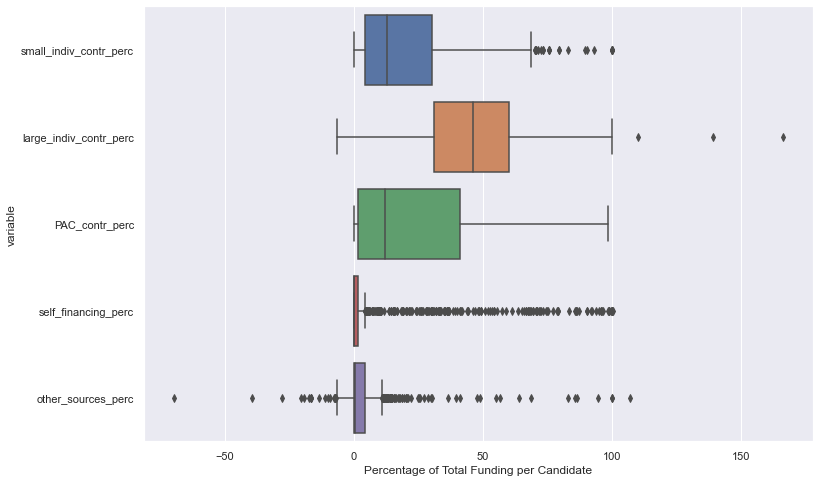

In [46]:
#removing that row
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=pd.melt(candidate_df.drop(529)[['small_indiv_contr_perc', 'large_indiv_contr_perc', 'PAC_contr_perc',
                                       'self_financing_perc', 'other_sources_perc']]), 
            x='value', 
            y='variable', 
            ax=ax
)
plt.xlabel('Percentage of Total Funding per Candidate');

We can see from the above, that on average, the most significant portions of a candidates funding come from large individual contributions. The PAC funding has a similar range to the large individual contribution range, but it's skewed right instead of fairly normally distributed. Similar to what we see in the distribution of funding by dollar amounts, the self-financing and other sources are primarily made up of outliers, indicating they are not typically a significant means of funding for most candidates. The spread of small individual contributions is primarily below 50% of total funding, but we do see some outliers of candidates who were primarily/entirely funding in this way

* Is there any detectable difference in contribution sources between Democrat and Republican candidates?

In [47]:
#Looking at the number of candidates associated with the various party designations
candidate_df['party'].value_counts()

D    423
R    387
I     46
L     21
3     15
Name: party, dtype: int64

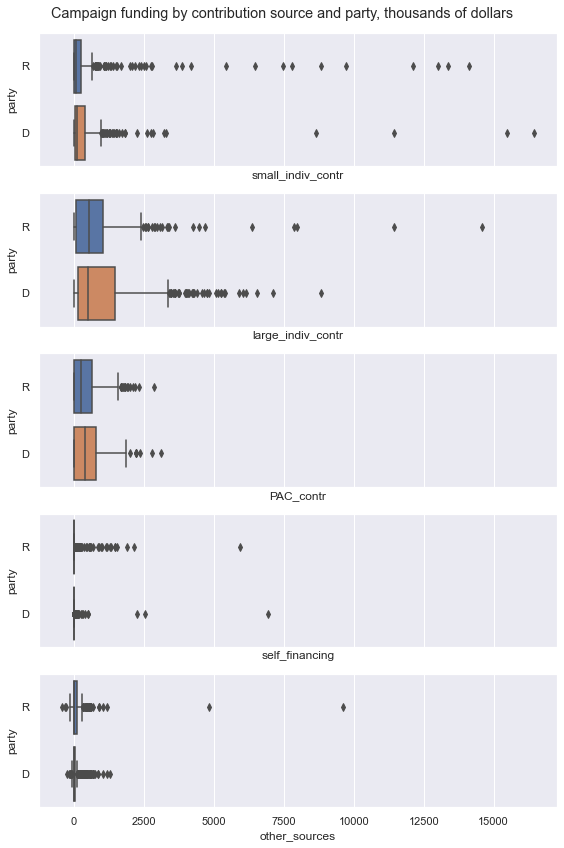

In [48]:
#Plotting the amounts raised by funding source in thousands of dollars, broken out by party for Democrats and Republicans
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and party, thousands of dollars')

ax = sns.boxplot(x=candidate_df['small_indiv_contr']/1000, 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot(x=candidate_df['large_indiv_contr']/1000, 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot(x=candidate_df['PAC_contr']/1000, 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot(x=candidate_df['self_financing']/1000, 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot(x=candidate_df['other_sources']/1000, 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[4])

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

The distributions in terms of dollar amounts are very similar for Republicans and Democrats with Democrats showing a bit more right skew with large individual and PAC contributions

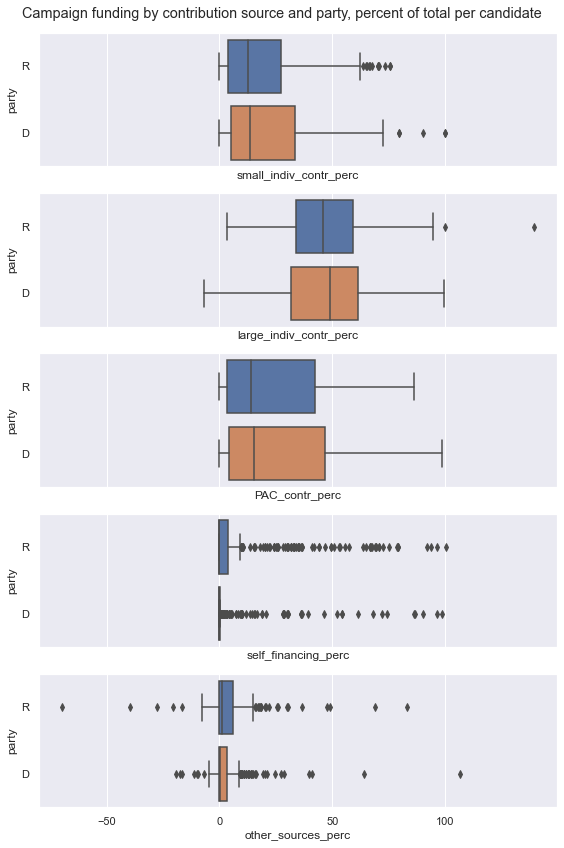

In [49]:
#Plotting the percent of total funding by funding source in thousands of dollars, broken out by party for Democrats and Republicans
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and party, percent of total per candidate')

ax = sns.boxplot(x='small_indiv_contr_perc', 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot(x='large_indiv_contr_perc', 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot(x='PAC_contr_perc', 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot(x='self_financing_perc', 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot(x='other_sources_perc', 
                 y="party", 
                 data=candidate_df.loc[candidate_df['party'].isin(['R', 'D'])], 
                 orient='h',
                 ax=axes[4])

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

The distributions looking at percent of funds raised are again very similar with Democrats showing a bit more right skew for small individual and PAC funding and Republicans showing a slight amount more right skew for self financing and other sources.

* Do the funding sources for either the winning candidate or incumbent candidate differ from the other candidates?

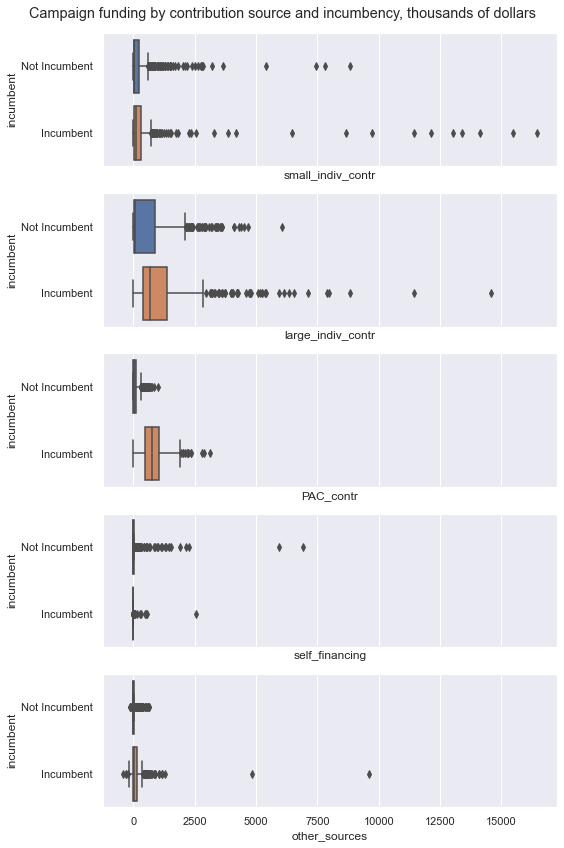

In [50]:
#Plotting the amounts raised by funding source in thousands of dollars, broken out by incumbency status
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and incumbency, thousands of dollars')

ax = sns.boxplot(x=candidate_df['small_indiv_contr']/1000, 
                 y="incumbent", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot(x=candidate_df['large_indiv_contr']/1000, 
                 y="incumbent", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot(x=candidate_df['PAC_contr']/1000, 
                 y="incumbent", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot(x=candidate_df['self_financing']/1000, 
                 y="incumbent", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot(x=candidate_df['other_sources']/1000, 
                 y="incumbent", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[4])
fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

These distributions indicate that on average, incumbent candidates bring in larger amounts of money from large individual contributions and PACs than do non-incumbent candidates. A few incumbent candidates also appear to have some very high total amounts brought in from small individual contributions, higher than any given to non-incumbent candidates.

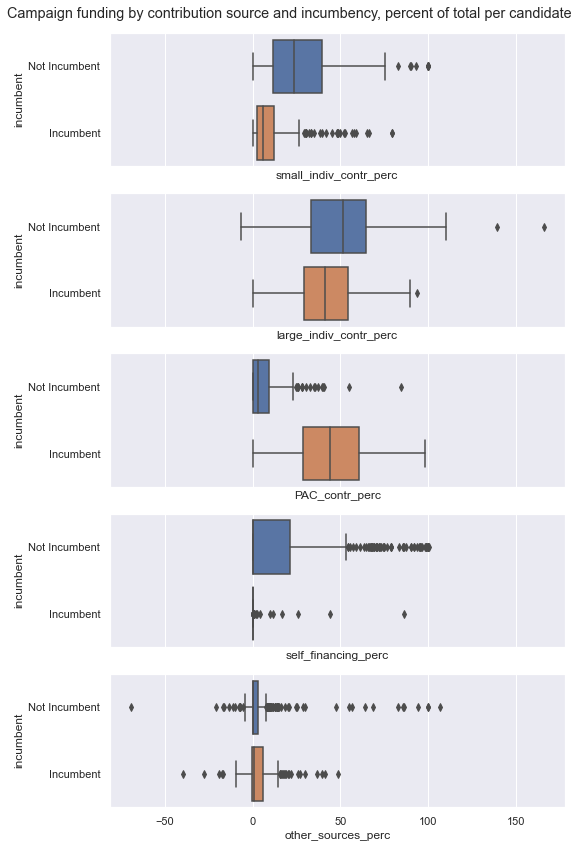

In [51]:
#Plotting the percent of total funding by funding source in thousands of dollars, broken out by incumbency
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and incumbency, percent of total per candidate')

ax = sns.boxplot('small_indiv_contr_perc', 
                 y="incumbent", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot('large_indiv_contr_perc', 
                 y="incumbent", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot('PAC_contr_perc', 
                 y="incumbent", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot('self_financing_perc', 
                 y="incumbent", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot('other_sources_perc', 
                 y="incumbent", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[4])
fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

These distributions show that on average incumbent candidates tend to get a lower portion of their funding from small individual contributions and large individual contributions, and a larger portion of their funding from PACs. There is also a much broader range for non-incumbents in terms of the proportion of funding supplied by self-financing indicating that non-incumbant candidates are comparitively more apt to get a significant portion of their funding via self-financing.

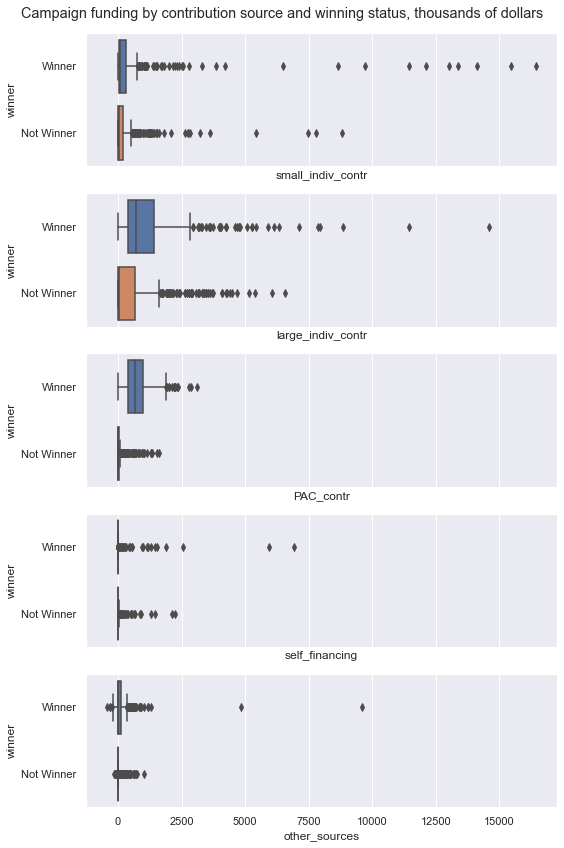

In [52]:
#Plotting the percent of total funding by funding source in thousands of dollars, broken out by winning status
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and winning status, thousands of dollars')

ax = sns.boxplot(x=candidate_df['small_indiv_contr']/1000, 
                 y="winner", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot(x=candidate_df['large_indiv_contr']/1000, 
                 y="winner", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot(x=candidate_df['PAC_contr']/1000, 
                 y="winner", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot(x=candidate_df['self_financing']/1000, 
                 y="winner", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot(x=candidate_df['other_sources']/1000, 
                 y="winner", 
                 data=candidate_df, 
                 orient='h',
                 ax=axes[4])

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

On average, those who win the race get larger amounts from large individual contributions and PACs.

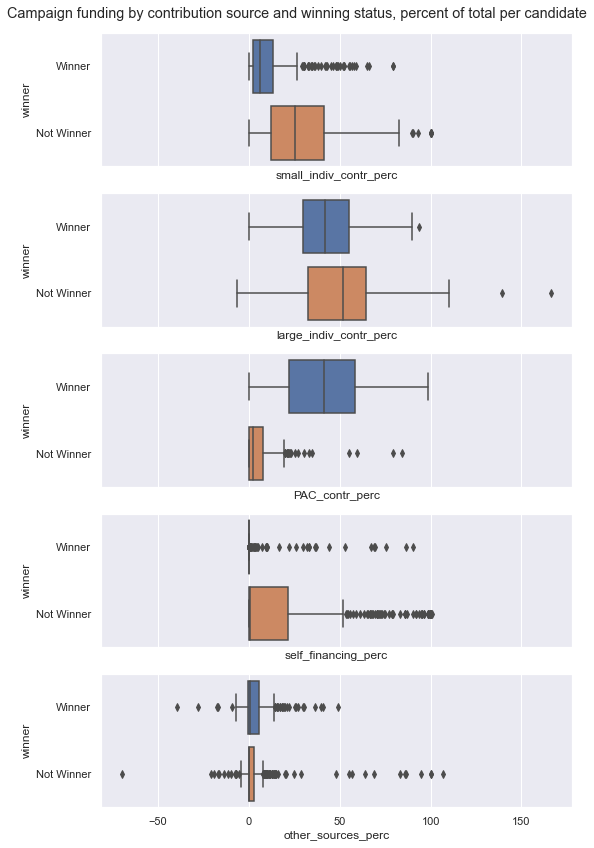

In [53]:
#Plotting the percent of total funding by funding source in thousands of dollars, broken out by winning status
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Campaign funding by contribution source and winning status, percent of total per candidate')

ax = sns.boxplot('small_indiv_contr_perc', 
                 y="winner", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[0])
ax = sns.boxplot('large_indiv_contr_perc', 
                 y="winner", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[1])
ax = sns.boxplot('PAC_contr_perc', 
                 y="winner", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[2])
ax = sns.boxplot('self_financing_perc', 
                 y="winner", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[3])
ax = sns.boxplot('other_sources_perc', 
                 y="winner", 
                 data=candidate_df.drop(index=529), 
                 orient='h',
                 ax=axes[4])

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

On average, those who win races get a smaller portion of their funding from small and large individual contributions, and significantly larger portions from PACs. The distribution for self-financing has a much wider range with a right skew for those who don't win races as compared to those who do.

### A different attempt at visualising contributions

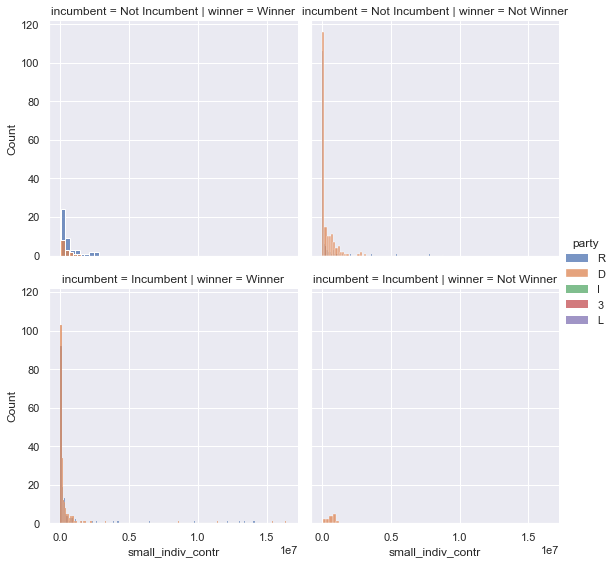

In [55]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'small_indiv_contr')
g.add_legend();

As evidenced by the plots above, visualising the histogram without any transformations will not work. Furthermore, the funding sources are sometimes 0 or negative. In order to visualize it better, used the function below:
- if less than 0, take the ln of the absolute value and then make negative again
- for values between 0 and 1 USD, simply put them at 0
- all other values, use ln

In [56]:
candidate_df['log_small_indiv_contr'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['small_indiv_contr']
]
candidate_df['log_large_indiv_contr'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['large_indiv_contr']
]
candidate_df['log_PAC_contr'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['PAC_contr']
]
candidate_df['log_self_financing'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['self_financing']
]
candidate_df['log_other_sources'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['other_sources']
]

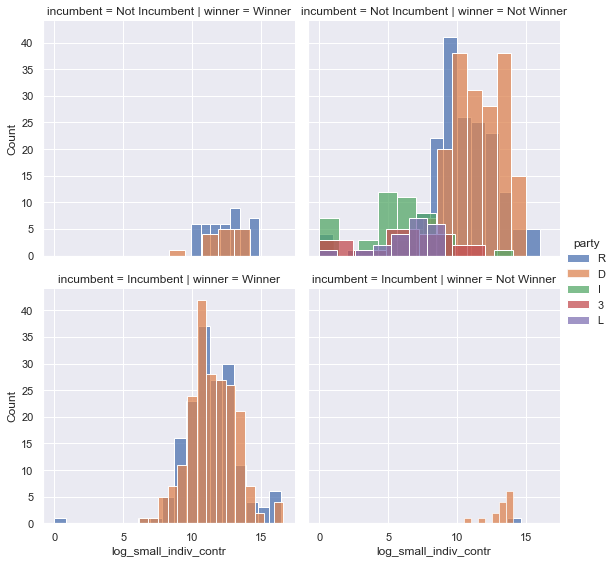

In [57]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log_small_indiv_contr')
g.add_legend();

For small individual contributions, the difference between R and D is not nearly as marked as it is between being incumbent, or winner

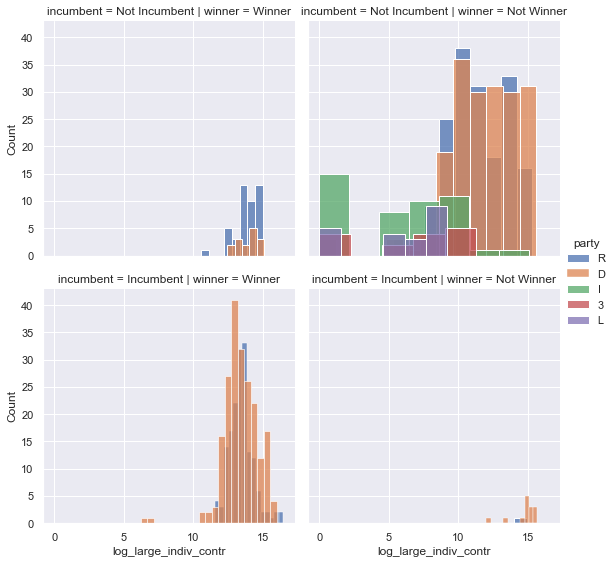

In [58]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log_large_indiv_contr')
g.add_legend();

Similar to before, with now winners & incumbent candidate having noticeably more financial support

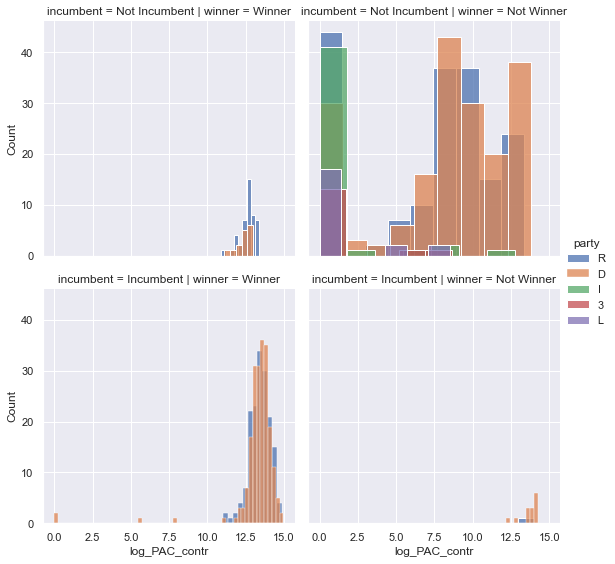

In [59]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log_PAC_contr')
g.add_legend();

PACs are investing much more heavily in incumbents (and they tend to be the winning candidates)

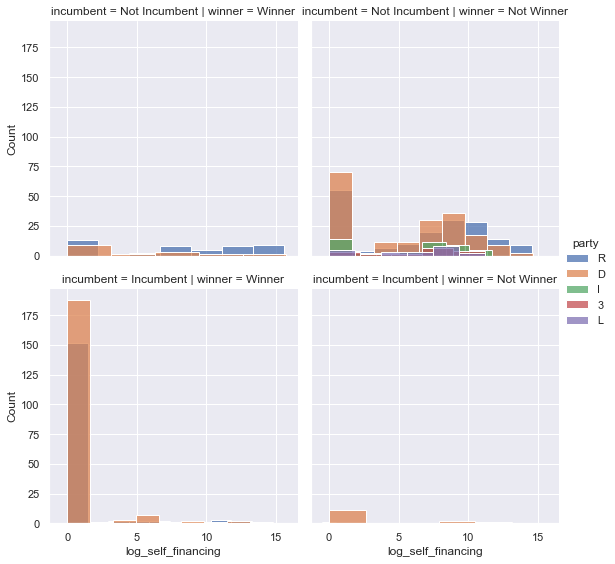

In [60]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log_self_financing')
g.add_legend();

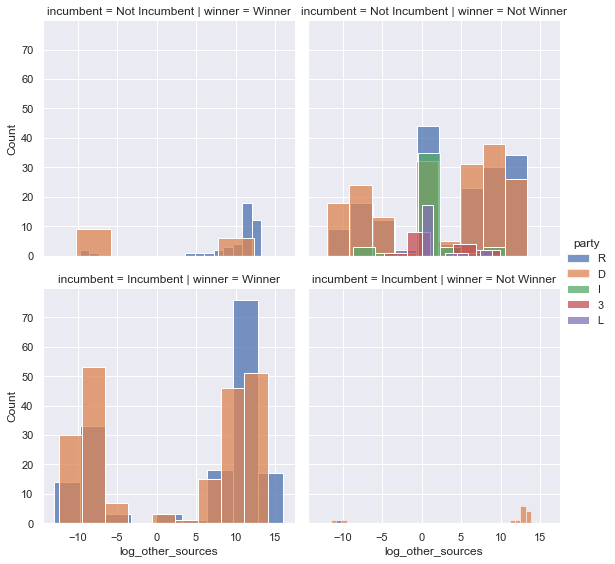

In [61]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log_other_sources')
g.add_legend();